In [ ]:
%run setup.py

In [ ]:
plt.style.use(['science'])

In [ ]:
koi = pd.read_csv('../data/koi.csv')
toi = pd.read_csv('../data/toi.csv')
AF_stars = pd.read_csv('../data/rev_AF_stars.csv')

In [ ]:
# df = votable_to_pandas('../data/toi_all_bj.vot')

In [10]:
# toi_nasa = pd.read_csv('../data/TOI_2020.03.29_18.00.47.csv', skiprows=94)
# toi_nasa

# TESS luminosities

In [ ]:
from astropy.io.votable import parse
import pandas as pd

def votable_to_pandas(votable_file):
    votable = parse(votable_file)
    table = votable.get_first_table().to_table(use_names_over_ids=True)
    return table.to_pandas()

In [16]:
from dustmaps.config import config
config['data_dir'] = '/Users/daniel/Desktop/dustmap/'

In [17]:
import dustmaps.leike_ensslin_2019

from astropy.coordinates import SkyCoord
from dustmaps.bayestar import BayestarQuery
from dustmaps.leike_ensslin_2019 import LeikeEnsslin2019Query
from astropy import units

leike = LeikeEnsslin2019Query()

def get_extinction_posterior(ra, dec, distance_posterior):
    coords = SkyCoord(ra=ra*units.deg, dec=dec*units.deg,
                          distance=distance_posterior*units.pc)
    reddening = leike(coords)

    if np.any(np.isnan(reddening)):
        return np.zeros(len(distance_posterior))
    
    return reddening

/Users/daniel/anaconda3/lib/python3.7/site-packages/dustmaps/leike_ensslin_2019.py:59: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(map_fname) as f:


In [18]:
import scipy.integrate as integrate
from scipy.stats import norm

def ud_distpost3(r,w,wsd,rlen):
    ud = d_like(w, r, wsd)*np.exp(-r/rlen)*(r**2)
    return ud

# Normalized Gaussian likelihood in w. Vectorized in any one parameter.
def d_like(w,r,wsd):
    return norm.pdf(w, 1/r, wsd)

def get_distance_posterior(plx, plx_err, rlen, r_est, N=100000):
    # DISTANCE CALCULATION
    w = (plx)*0.001
    wsd = (plx_err)*0.001
    
    if r_est < 1000:
        scale = 0.01
    else:
        scale = 10
    
    rlo, rhi = r_est-scale*rlen, r_est+scale*rlen
    if rlo < 0:
        rlo = 1e-10
    rplot = np.linspace(rlo,rhi,N)
    dprior = (1/(2*rlen**3))*np.exp(-rplot/rlen)*rplot**2
    dpost  = ud_distpost3(rplot, w, wsd, rlen)
    
    integ = integrate.quad(ud_distpost3, rlo, rhi, args=(w,wsd,rlen))
    dpost_norm = dpost/integ[0]
    
    rlo, rhi = rplot[dpost_norm > 1e-20][0], rplot[dpost_norm > 1e-20][-1]
    rplot = np.linspace(rlo,rhi,N)
    dprior = (1/(2*rlen**3))*np.exp(-rplot/rlen)*rplot**2
    dpost  = ud_distpost3(rplot, w, wsd, rlen)
    integ = integrate.quad(ud_distpost3, rlo, rhi, args=(w,wsd,rlen))
    dpost_norm = dpost/integ[0]
#     distance = rplot[np.argmax(dpost_norm)]

    values = dpost_norm
    arr2 = (values - values.min()) / (values.max() - values.min())
    arr2 /= arr2.sum()
    posterior_norm = np.random.choice(rplot,size=N, p=arr2)
    
    return posterior_norm

In [19]:
from scipy.interpolate import RegularGridInterpolator
import h5py

bcmodel = h5py.File('../data/bcgrid.h5', 'r')
interp = RegularGridInterpolator((np.array(bcmodel['teffgrid']), \
        np.array(bcmodel['logggrid']),np.array(bcmodel['fehgrid']), \
            np.array(bcmodel['avgrid'])),np.array(bcmodel['bc_ga'])) 

def getbc_posterior(teff, logg=4., feh=0.,N=100000):
    try:
        bc = interp(np.array([teff,logg,feh,0]))[0]
    except:
        bc = 0.
    return np.random.normal(bc, 0.04, N)

In [20]:
mask = np.isnan(df['plx'])
df = df[~mask]

In [21]:
from tqdm import tqdm

def getbc(teff,logg,feh,av):
    return interp(np.array([teff,logg,feh,av]))[0]

def log_L_bol(mag, distance, extinction, BC):
    return (-((mag - 5*(np.log10(distance)-1) - extinction) + BC - 4.74)/2.5)

N = 100000
values = []
for index, row in tqdm(df[:].iterrows(), total=df.shape[0]):
    distance = get_distance_posterior(row['plx'], row['e_plx'], row['r_len'], row['r_est'], N=N)
    extinction = get_extinction_posterior(row['ra'], row['dec'], distance)
        
    logg = 4.
    feh = 4.
    bc = getbc_posterior(row['stellar_teff__k_'], logg=logg, feh=feh, N=N)
    mag = np.random.normal(row['gaiamag'], row['e_gaiamag'], N)
    
    val = log_L_bol(mag, distance, extinction, bc)
    
    values.append([np.mean(val), np.median(val), np.percentile(val,84.13), np.percentile(val,15.86), np.std(val), np.median(bc), row['id']])

100%|██████████| 577/577 [00:38<00:00, 15.15it/s]


In [22]:
tic = [int(value[-1]) for value in values]

In [24]:
values = np.array(values)
lum_df = pd.DataFrame({
    'ID': tic,
    'MC_LUM': values[:,0],
    'MC_LUM_SD': values[:,4],
    'MC_LUM_MED': values[:,1],
    'MC_LUM_UPPER': values[:,2],
    'MC_LUM_LOWER': values[:,3]
})

In [25]:
toi_lum = toi.merge(lum_df, left_on='TIC ID', right_on='ID')

# HRD

In [5]:
# toi_lum = pd.read_csv('../data/toi_lum.csv')
# toi_lum = toi_lum[toi_lum['TIC ID'].isin(toi_dsct)]
# # [print(col) for col in toi_lum.columns];

In [6]:
# Stellar tracks
Lcolnames = ["T11", "L11", "G11", "T12", "L12", "G12", "T13", "L13", "G13", "T14", "L14", "G14", "T15", "L15", "G15", "T16", "L16", "G16", "T17", "L17", "G17", "T18", "L18", "G18", "T19", "L19", "G19", "T20", "L20", "G20", "T21", "L21", "G21", "T22", "L22", "G22", "T23", "L23", "G23", "T24", "L24", "G24", "T25", "L25", "G25"]
Ltracks = pd.read_csv("../data/tracks/mesa10108_as09_opal_exp150_mlt180_D000_z140x071_orig.csv",  header=None, sep=" ", names=Lcolnames, skiprows=([0]))
msL = pd.DataFrame(data={"Tms": Ltracks.loc[0][0::3].values, "Lms": Ltracks.loc[0][1::3].values, "Gms": Ltracks.loc[0][2::3].values})

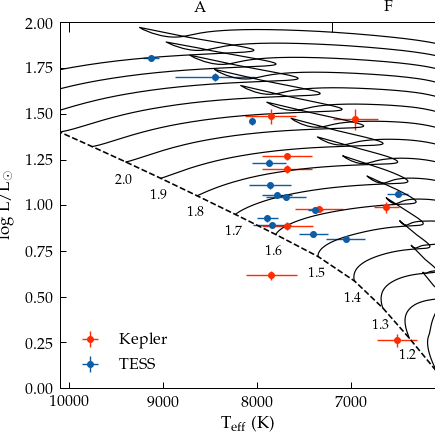

In [7]:
plt.figure(figsize=mnras_size(242.26653, square=True))
# plt.figure(figsize=[10,10])
# # plot evolutionary tracks
# for n in np.arange(0,-8+len(oLcolnames)/3):
#     plt.plot(oLtracks.iloc[:,int(3*n+0)],oLtracks.iloc[:,int(3*n+1)],"g-",linewidth=0.8,label='old')

for n, mass in zip(np.arange(0,len(Lcolnames)/3), np.arange(1.1,2.7,0.1)):
    plt.plot(Ltracks.iloc[:,int(3*n+0)],Ltracks.iloc[:,int(3*n+1)],c='black',linewidth=0.6)
    if (mass > 1.2) & (mass < 2.1):
        plt.text(Ltracks.iloc[:,int(3*n+0)][0]+20, Ltracks.iloc[:,int(3*n+1)][0]-0.1, str(np.round(mass,2)), c='black',horizontalalignment='center',verticalalignment='center', fontsize=7)
plt.plot(msL['Tms'], msL['Lms'], c='black', linewidth=0.8, linestyle='dashed')
# give the plot frame the right parameters / aesthetics
plt.xlabel(r"T$_{\rm eff}$ (K)")
plt.ylabel(r"log L/L$_{\odot}$")
plt.ylim(0.0,2.)
plt.xlim(6100,10100)
plt.gca().invert_xaxis()

af_dsct = AF_stars[AF_stars.kic.isin(koi[koi['dsct']==True].kepid)]
plt.errorbar(af_dsct['Teffi'], af_dsct['loglbol_g_median'], yerr=[af_dsct['loglbol_sigp'], af_dsct['loglbol_sigm']], 
             xerr=af_dsct['e_Teffi'], fmt='.', c='C3', label='Kepler', elinewidth=0.7, markersize=5,
#             markeredgecolor='white'
            )

toi_lum = toi[toi['dsct'] == True]
plt.errorbar(toi_lum['Stellar Teff (K)'], toi_lum['MC_LUM'], yerr=toi_lum['MC_LUM_SD'], 
             xerr=toi_lum['Stellar Teff error'], fmt='.', c='C0', label='TESS', elinewidth=0.7, markersize=5,
#             markeredgecolor='white'
            )

plt.legend(fontsize=8)

colors = np.array([
    [146,181,255],
    [162,192,255],
    [213,224,255],
    [249,245,255],
    [255,237,227],
    [255,218,181],
    [255,181,108]
]) / 255

classes = np.array([
    [30000, 50000],
    [10000,10500],
    [7200,10000],
    [6000,7200],
    [5200,6000],
    [3700,5200],
    [3000,3700]
])


ax2 = plt.twiny()
ax2.set_xlim(10100,6100)


# Major ticks
ticks2 = [3700,5200,6000,7200,10000]
ax2.set_xticks(ticks2)
ax2.set_xticklabels([])
ax2.tick_params(axis='x', which="major", length=5)
ax2.set_xlim(10100,6100)

# Minor ticks
ticks1 = np.average(classes, axis=1)
labs = ['O', 'B', 'A', 'F', 'G', 'K', 'M']
ax2.set_xticks(ticks1, minor=True)
ax2.set_xticklabels(labs, minor=True)
ax2.tick_params(axis='x', which="minor",length=0)
ax2.set_xlim(10100,6100)

plt.savefig(overleaf_path + 'HRD.pdf')

# plt.savefig('test_notex.png', dpi=300)

# Masses

In [45]:
Ltracks = pd.read_csv('../data/tracks/mesa10108_as09_opal_exp150_mlt180_D000_z100x071_refined_withage.csv',  header=None, sep=" ", skiprows=([0]))

temp = Ltracks[0].values
lum = Ltracks[1].values
mass = np.array([1.1]*len(Ltracks[0]))
                
for track in np.arange(0,156, 4):
    temp = np.concatenate((temp, Ltracks[track].values))
    lum = np.concatenate((lum, Ltracks[track+1].values))
    mass = np.concatenate((mass, np.array([1.10 + (track/4)*0.05]*len(Ltracks[track]))))

In [47]:
from scipy.interpolate import griddata

mass_interp = []
for index, row in toi_lum.iterrows():
    mass_interp.append(griddata((np.array(temp), np.array(lum)),np.array(mass),[row['Stellar Teff (K)'], row['MC_LUM']],method='cubic')[0])
toi_lum['mass_interp'] = mass_interp

In [198]:
# Evolutionary tracks for stars in or close to the delta Sct instability strip. Masses vary from 1.0 to 3.0 Msol, with a step of 0.05 Msol. Four columns per mass: Teff, logL, logg and age.
tracks = np.loadtxt('../data/tracks/mesa10108_as09_opal_exp150_mlt180_D000_z100x071_refined_withage.csv', skiprows=1).T
# 2nd ind: 0 - temp, 1 - logl, 2 - logg, 3 - age
tracks = tracks.reshape(41, 4, 600)

teffs = tracks[:,0,:]
lums = tracks[:,1,:]
loggs = tracks[:,2,:]

# for track in tracks:
#     plt.plot(track[0], track[1])

# plt.figure(figsize=[10,5])

# teffs = []
# lums = []
# masses = []

# for i, track in enumerate(tracks[:]):
#     shaped = track.reshape(41,4)
#     teff, lum, logg = shaped[:,0], shaped[:,1], shaped[:,2]
#     plt.plot(teff, lum, linewidth=0.1, c=blue)

# Stellar tracks
# Lcolnames = ["T11", "L11", "G11", "T12", "L12", "G12", "T13", "L13", "G13", "T14", "L14", "G14", "T15", "L15", "G15", "T16", "L16", "G16", "T17", "L17", "G17", "T18", "L18", "G18", "T19", "L19", "G19", "T20", "L20", "G20", "T21", "L21", "G21", "T22", "L22", "G22", "T23", "L23", "G23", "T24", "L24", "G24", "T25", "L25", "G25"]
# Ltracks = pd.read_csv("../data/tracks/mesa10108_as09_opal_exp150_mlt180_D000_z140x071_orig.csv",  header=None, sep=" ", names=Lcolnames, skiprows=([0]))
# msL = pd.DataFrame(data={"Tms": Ltracks.loc[0][0::3].values, "Lms": Ltracks.loc[0][1::3].values, "Gms": Ltracks.loc[0][2::3].values})

# for n, mass in zip(np.arange(0,len(Lcolnames)/3), np.arange(1.1,2.7,0.1)):
#     plt.plot(Ltracks.iloc[:,int(3*n+0)],Ltracks.iloc[:,int(3*n+1)],c='black',linewidth=0.6)
#     if (mass > 1.2) & (mass < 2.2):
#         plt.text(Ltracks.iloc[:,int(3*n+0)][0]+20, Ltracks.iloc[:,int(3*n+1)][0]-0.1, str(np.round(mass,2)), c='black',horizontalalignment='center',verticalalignment='center', fontsize=7)
# plt.plot(msL['Tms'], msL['Lms'], c='black', linewidth=0.8, linestyle='dashed')
# plt.xlim(10000,6500)

In [240]:
from scipy.interpolate import interp2d

t_flat = teffs.flatten()
l_flat = lums.flatten()
sort = np.argsort(t_flat)
t_flat = t_flat[sort]
l_flat = l_flat[sort]

In [ ]:
interp2d(t_flat, l_flat, np.ones(24600))

In [231]:
%timeit griddata((t_flat, l_flat), np.ones((24600)), (6500, 1.))

359 ms ± 33.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [239]:
(10000*0.359) / 60 

0.9972222222222222

In [202]:
data.shape

(11, 22, 33)

In [205]:
x.shape, y.shape, z.shape

((11,), (22,), (33,))

In [206]:
x

array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ])

In [213]:
from scipy.interpolate import griddata

tracks_combined = tracks[:,0:2,:]
masses = np.ones_like(tracks_combined)
mass_lin = np.linspace(1, 3, 41)

for i, mass in enumerate(mass_lin):
    masses[i,:,:] = mass

ValueError: The points in dimension 0 must be strictly ascending

# To paper table

In [81]:
for index, row in toi_lum.sort_values('TIC ID').iterrows():
    print(f"TIC {row['TIC ID']} \t & {row['TESS Disposition']} \t \
    & {row['Stellar Teff (K)']:.0f} $\pm$ {row['Stellar Teff error']:.0f} \t \
    & {row['MC_LUM']:.2f} $\pm$ {row['MC_LUM_SD']:.2f} \t \
    & {1.} \t \
    & {row['Period (days)']:.4f} $\pm$ {row['Period error']:.4f} \\\\")

TIC 80275202 	 & PC 	     & 7889 $\pm$ 115 	     & 0.93 $\pm$ 0.02 	     & 1.0 	     & 3.6646 $\pm$ 0.0007 \\
TIC 89759617 	 & PC 	     & 7873 $\pm$ 183 	     & 1.23 $\pm$ 0.02 	     & 1.0 	     & 3.3304 $\pm$ 0.0007 \\
TIC 120269103 	 & PC 	     & 8446 $\pm$ 422 	     & 1.70 $\pm$ 0.02 	     & 1.0 	     & 6.5976 $\pm$ 0.0068 \\
TIC 156987351 	 & PC 	     & 7691 $\pm$ 215 	     & 1.04 $\pm$ 0.02 	     & 1.0 	     & 3.0630 $\pm$ 0.0005 \\
TIC 193413306 	 & PC 	     & 6502 $\pm$ 114 	     & 1.06 $\pm$ 0.02 	     & 1.0 	     & 1.7260 $\pm$ 0.0002 \\
TIC 202563254 	 & PC 	     & 7787 $\pm$ 158 	     & 1.06 $\pm$ 0.02 	     & 1.0 	     & 4.4733 $\pm$ 0.0032 \\
TIC 255704097 	 & PC 	     & 7836 $\pm$ 202 	     & 0.89 $\pm$ 0.02 	     & 1.0 	     & 6.0152 $\pm$ 0.0003 \\
TIC 295599256 	 & PC 	     & 7860 $\pm$ 220 	     & 1.11 $\pm$ 0.02 	     & 1.0 	     & 7.1439 $\pm$ 0.0005 \\
TIC 372913430 	 & PC 	     & 9125 $\pm$ 85 	     & 1.81 $\pm$ 0.02 	     & 1.0 	     & 13.4779 $\pm$ 0.0001 \\
TIC